In [1]:
# avoid non-compliant Type 3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from munch import Munch
from tqdm import notebook as notebook

import datasets
import models
from pose_estimation import models as pose_models
from pose_estimation import utils as pose_utils
from segmentation import models as segm_models

In [3]:
data_root = 'data/OilChangeDataset'
ann_file = '20171103_OilChange.json'
camera_name = 'floating_kinect1'
cache_dir = 'cache/eval/'
segm_config_path = 'segmentation/pretrained/drn_d_22_OilChange/config.yml'
pose_config_path = 'pose_estimation/pretrained/floating_kinect1_mask/config.yml'
#pose_config_path = 'pose_estimation/pretrained/floating_kinect1_mask_with_occlusion/config.yml'

In [4]:
with open(segm_config_path, 'r') as f:
    segm_cfg = Munch.fromYAML(f)
    segm_cfg.training.resume = os.path.join('segmentation', segm_cfg.training.resume)
with open(pose_config_path, 'r') as f:
    pose_cfg = Munch.fromYAML(f)
    pose_cfg.training.resume = os.path.join('pose_estimation', pose_cfg.training.resume)

In [5]:
cudnn.benchmark = True

In [6]:
segm_model = segm_models.DRNSeg(segm_cfg.arch, segm_cfg.data.classes, None, pretrained=True)
segm_model = torch.nn.DataParallel(segm_model)
segm_checkpoint = torch.load(segm_cfg.training.resume, map_location='cpu')
segm_model.load_state_dict(segm_checkpoint['state_dict'])
print("=> loaded checkpoint '{}' (epoch {})".format(segm_cfg.training.resume, segm_checkpoint['epoch']))

=> loaded checkpoint 'segmentation\pretrained/drn_d_22_OilChange/checkpoint_00000900.pth.tar' (epoch 900)


In [7]:
pose_model = pose_models.Model(pose_cfg.arch)
pose_model = torch.nn.DataParallel(pose_model)
pose_checkpoint = torch.load(pose_cfg.training.resume, map_location='cpu')
pose_model.load_state_dict(pose_checkpoint['state_dict'])
print("=> loaded checkpoint '{}' (epoch {})".format(pose_cfg.training.resume, pose_checkpoint['epoch']))

=> loaded checkpoint 'pose_estimation\pretrained/floating_kinect1_mask/checkpoint_00002100.pth.tar' (epoch 2100)


In [8]:
transform = transforms.ToTensor()
val_dataset = datasets.EvalDataset(data_root, 'val_' + ann_file, camera_name, pose_cfg.data.objects, transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=0, pin_memory=True)

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!
using camera: floating_kinect1


In [9]:
model = models.EndToEndEvalModel(segm_model, pose_model)
model.eval();

In [10]:
def forward_batch(model, input, target, object_index, object_id):
    #target = target.cuda(non_blocking=True)
    #object_index = object_index.cuda(non_blocking=True)
    #object_id = object_id.cuda(non_blocking=True)

    position, orientation = model(input, object_index, object_id)
    position_error = (target[:, :3] - position).pow(2).sum(dim=1).sqrt()
    orientation_error = 180.0 / np.pi * pose_utils.batch_rotation_angle(target[:, 3:], orientation)
    
    return position_error.cpu().numpy(), orientation_error.cpu().numpy()

In [11]:
position_errors = []
orientation_errors = []
with torch.no_grad():
    for input, target, object_index, object_id in notebook.tqdm(val_loader):
        position_error, orientation_error = forward_batch(model, input, target, object_index, object_id)
        position_errors.extend(position_error)
        orientation_errors.extend(orientation_error)
position_errors = 100.0 * np.array(position_errors)
orientation_errors = np.array(orientation_errors)

  0%|          | 0/683 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
print('mean position error: {:.2f}'.format(position_errors.mean()))
print('mean orientation error: {:.2f}'.format(orientation_errors.mean()))
print('median position error: {:.2f}'.format(np.median(position_errors)))
print('median orientation error: {:.2f}'.format(np.median(orientation_errors)))
success = (position_errors < 5) * (orientation_errors < 15)
print('success: {:.2f}'.format(100.0 * sum(success) / len(position_errors)))

mean position error: 3.76
mean orientation error: 19.64
median position error: 3.23
median orientation error: 6.17
success: 71.01


In [ ]:
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
cache_path = os.path.join(cache_dir, '{}.npy'.format(pose_cfg.training.experiment_name))
np.save(cache_path, (position_errors, orientation_errors))

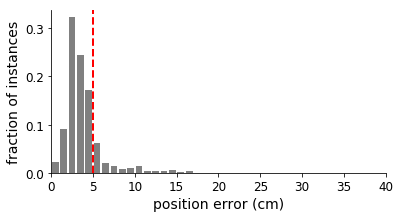

In [ ]:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.hist(position_errors, bins=np.arange(40 + 1), density=True, rwidth=0.8, color='gray')
plt.axvline(x=5, ls='--', lw=2, c='r')
plt.xlabel('position error (cm)', fontsize=14)
plt.ylabel('fraction of instances', fontsize=14)
plt.xlim(0, 40)
plt.savefig('figures/errors_position.pdf', bbox_inches='tight')

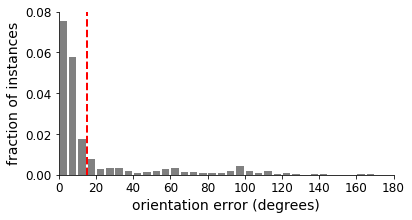

In [ ]:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.hist(orientation_errors, bins=np.arange(0, 180 + 1, 5), density=True, rwidth=0.8, color='gray')
plt.axvline(x=15, ls='--', lw=2, c='r')
plt.xlabel('orientation error (degrees)', fontsize=14)
plt.ylabel('fraction of instances', fontsize=14)
plt.xlim(0, 180)
plt.ylim(0, 0.08)
plt.savefig('figures/errors_orientation.pdf', bbox_inches='tight')

In [ ]:
# comparison of orientation errors for models trained with and without occlusion
cache_path_wo_occlusion = os.path.join(cache_dir, '{}.npy'.format('floating_kinect1_mask'))
cache_path_with_occlusion = os.path.join(cache_dir, '{}.npy'.format('floating_kinect1_mask_with_occlusion'))
position_errors_wo_occlusion, orientation_errors_wo_occlusion = np.load(cache_path_wo_occlusion)
position_errors_with_occlusion, orientation_errors_with_occlusion = np.load(cache_path_with_occlusion)

FileNotFoundError: [Errno 2] No such file or directory: 'cache/eval/floating_kinect1_mask_with_occlusion.npy'

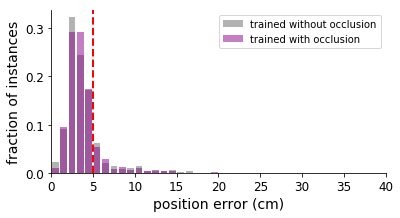

In [ ]:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.hist(position_errors_wo_occlusion, bins=np.arange(40 + 1),
         density=True, rwidth=0.8, alpha=0.5, label='trained without occlusion', color='dimgray')
plt.hist(position_errors_with_occlusion, bins=np.arange(40 + 1),
         density=True, rwidth=0.8, alpha=0.5, label='trained with occlusion', color='darkmagenta')
plt.axvline(x=5, ls='--', lw=2, c='r')
plt.xlabel('position error (cm)', fontsize=14)
plt.ylabel('fraction of instances', fontsize=14)
plt.xlim(0, 40)
plt.legend()
plt.savefig('figures/errors_position_with_occlusion.pdf', bbox_inches='tight')

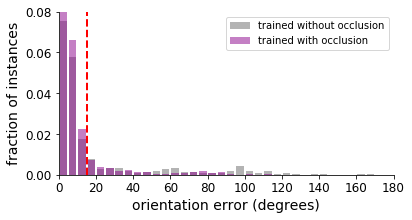

In [ ]:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.hist(orientation_errors_wo_occlusion, bins=np.arange(0, 180 + 1, 5),
         density=True, rwidth=0.8, alpha=0.5, label='trained without occlusion', color='dimgray')
plt.hist(orientation_errors_with_occlusion, bins=np.arange(0, 180 + 1, 5),
         density=True, rwidth=0.8, alpha=0.5, label='trained with occlusion', color='darkmagenta')
plt.axvline(x=15, ls='--', lw=2, c='r')
plt.xlabel('orientation error (degrees)', fontsize=14)
plt.ylabel('fraction of instances', fontsize=14)
plt.xlim(0, 180)
plt.ylim(0, 0.08)
plt.legend()
plt.savefig('figures/errors_orientation_with_occlusion.pdf', bbox_inches='tight')